# Compulsory Assignment 1 DAT 300
Group 18? - teamme - Stian Teien

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


#for kaggle
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [4]:
tf.random.set_seed(42)

## Prepare data
I want the data to be scaled down and split it into three sets total.
* Train set - to train our models
* Validation set - to check for overfitting and get a good estimator for r2 score
* Test set - to test in compition

In [2]:
X_train_origin = pd.read_csv('X_train.csv')
y_train_origin = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')


#X_train_origin = pd.read_csv('/kaggle/input/concretedata/X_train.csv')
#y_train_origin = pd.read_csv('/kaggle/input/concretedata/y_train.csv')
#X_test = pd.read_csv('/kaggle/input/concretedata/X_test.csv')


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_origin, y_train_origin, test_size=0.2, random_state=42)

In [4]:
X_train

Cement (component 1)(kg in a m^3 mixture)  \
531                                     165.00   
364                                     122.60   
177                                     165.00   
593                                     393.00   
199                                     183.90   
..                                         ...   
71                                      181.38   
106                                     170.30   
270                                     480.00   
435                                     236.90   
102                                     290.35   

     Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
531                                               0.02       
364                                             183.90       
177                                               0.02       
593                                               0.00       
199                                             122.60       
..                                                 ...       
71                                                0.00       
106                                             155.50       
270                                               0.00       
435                                              91.70       
102                                               0.00       

     Fly Ash (component 3)(kg in a m^3 mixture)  \
531                                      143.57   
364                                        0.00   
177                                      143.57   
593                                        0.00   
199                                        0.00   
..                                          ...   
71                                       167.01   
106                                        0.00   
270                                        0.00   
435                                       71.50   
102                                       96.18   

     Water  (component 4)(kg in a m^3 mixture)  \
531                                     163.81   
364                                     203.50   
177                                     163.81   
593                                     192.00   
199                                     203.50   
..                                         ...   
71                                      169.59   
106                                     185.70   
270                                     192.00   
435                                     246.90   
102                                     168.08   

     Superplasticizer (component 5)(kg in a m^3 mixture)  \
531                                               0.00     
364                                               0.00     
177                                               0.00     
593                                               0.00     
199                                               0.00     
..                                                 ...     
71                                                7.56     
106                                               0.00     
270                                               0.00     
435                                               6.00     
102                                               9.41     

     Coarse Aggregate  (component 6)(kg in a m^3 mixture)  \
531                                            1005.60      
364                                             958.20      
177                                            1005.60      
593                                             940.00      
199                                             959.20      
..                                                 ...      
71                                             1055.60      
106                                            1026.60      
270                                             936.20      
435                                             852.90      
102                                             961.1

In [7]:
#MinMaxscale
#feature_range=(min, max)
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
X_train_scale = min_max_scaler.fit_transform(X_train)
X_val_scale = min_max_scaler.fit_transform(X_val)

# Standarised
sc = preprocessing.StandardScaler()
X_train_stand = sc.fit_transform(X_train)
X_val_stand = sc.fit_transform(X_val)

X_test_scale = min_max_scaler.fit_transform(X_test)


## Linear regression and random forest
Uses `sklearn` to make a linear regression and random forest. Compute the r2 score on validation data.

In [54]:
# Make a linear model
reg = LinearRegression().fit(X_train_scale, y_train)
reg.score(X_val_scale, y_val)

0.5940480286236506

In [55]:
# Make a random forest

regr = RandomForestRegressor(max_depth=10, random_state=42).fit(X_train_scale, y_train)
regr.score(X_val_scale, y_val)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8199225425643926

## Keras model
Make a keras model. Adding callback earlystopping for finding best epoch faster.  
Technical things:  
* Optimizer &rarr; `adam`
* loss &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &rarr; `mean square error`, good for this
* metrics &nbsp;&nbsp;&nbsp; &rarr; `mean average error` (how far away from truth), `mean_absolute_percentage_error` (get % on how far from truth)

In [8]:
# Keras model

def make_model(neurons=[512, 512]):

    model = keras.Sequential(name='concretemodel')
    
    model.add(keras.Input(shape=(8,)))
    for n_neurons in neurons:
        model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer='l1_l2', bias_regularizer='l2', activity_regularizer='l2'))
        model.add(keras.layers.Dropout(0.2))
    
    #model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    
    
    model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mean_absolute_percentage_error'])
    
    return model

### Cross validation
Since the data set is so small we do a cross validation to find average estimates.

processing fold 1 of 4
==> In fold 1 it ran 500
processing fold 2 of 4
==> In fold 2 it ran 500
processing fold 3 of 4
==> In fold 3 it ran 500
processing fold 4 of 4
==> In fold 4 it ran 500


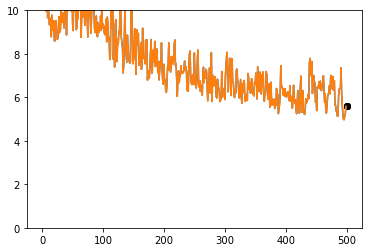

In [90]:
num_epochs = 500
all_val_loss_histories = []
all_loss_histories = []
k=4
num_val_samples = len(X_train_scale) // k
patience = 50
forslag = []

for i in range(k):
    print(f'processing fold {i+1} of {k}')
    
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([X_train[:i * num_val_samples],
                                         X_train[(i + 1) * num_val_samples:]],
                                         axis=0)
    
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],
                                            y_train[(i + 1) * num_val_samples:]],
                                            axis=0)

    # Build the Keras model (already compiled)
    model = make_model()
    
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=42, verbose=0)
                        #callbacks= [keras.callbacks.EarlyStopping(
                        #            monitor='val_loss', patience=patience, restore_best_weights=True)])

    
    forslag.append(len(history.history["val_loss"]) - 1 - patience if len(history.history["val_loss"]) < num_epochs else num_epochs)
    val_loss_history = history.history['val_mae']
    loss_history = history.history['val_mae']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    print(f'==> In fold {i+1} it ran {len(history.history["val_loss"])}')

    
# Finding average of all
avg_val_loss_history = []
avg_all_loss_histories = []
longest = len(max(all_val_loss_histories, key=len))
for i in range(longest):
    samlet_verdier = [all_val_loss_histories[j][i]for j in range(len(all_val_loss_histories)) if len(all_val_loss_histories[j]) > i]
    avg_val_loss_history.append(np.mean(samlet_verdier))
    
    samlet_verdier = [all_loss_histories[j][i]for j in range(len(all_loss_histories)) if len(all_loss_histories[j]) > i]
    avg_all_loss_histories.append(np.mean(samlet_verdier))

avg_forslag = int(np.mean(forslag))

# Print the losses
plt.plot(avg_val_loss_history)
plt.plot(avg_all_loss_histories)
for i in forslag:
    plt.scatter(i, avg_val_loss_history[i-1], c='Black')
#plt.scatter(avg_forslag, avg_val_loss_history[avg_forslag], c="green")
plt.ylim([0,10])
plt.show()

In [ ]:
# Fresh model
model = make_model()
epochs = avg_forslag

history = model.fit(X_train, y_train, verbose=0, 
                    batch_size=42,
                    epochs=epochs )

model.evaluate(X_val, y_val)
print(f'r2 score on val set: {r2_score(y_val,model.predict(X_val))}')

## Alterinative method on finding best model
Just by using a validation set and earlystop I can get a better score

In [9]:
def run_sim(params=[[512,512]]):
    for param in params:
        tf.random.set_seed(42)
        print(f'running param: {param}')
        monitor = 'loss'
        model = make_model(neurons=param)
        patience = 50
        history = model.fit(X_train_scale, y_train, verbose=0, 
                            batch_size=32,
                            epochs=1000, validation_data=(X_val_scale, y_val),
                            callbacks= [keras.callbacks.EarlyStopping(
                                monitor='val_'+monitor, patience=patience, restore_best_weights=True)])

        lenth = len(history.history['mae'])
        print(f"epochs before stop: {lenth}")

        model.evaluate(X_val_scale, y_val)
        print(f'r2 score on val set: {r2_score(y_val,model.predict(X_val_scale))}')


        plt.plot(history.history[monitor], c='blue', label='train')
        plt.plot(history.history['val_'+monitor], c='red', label='val')
        plt.text(lenth-1-patience, history.history['val_'+monitor][lenth-1-patience],'model score I pick')
        plt.scatter(lenth-1-patience, history.history['val_'+monitor][lenth-1-patience], c='black')
        plt.legend()

        plt.ylim([0,80])
        plt.show()
        
        return model

### Gridsearch best params on amount of neurons
I think the activaction function and optimzer is good enough, so the most variancion can be from amount of neurons

running param: [512, 512, 512, 128]
epochs before stop: 295
124/124 [==============================] - 0s 346us/sample - loss: 59.1880 - mae: 4.4129 - mean_absolute_percentage_error: 14.0517
r2 score on val set: 0.8515634288293646


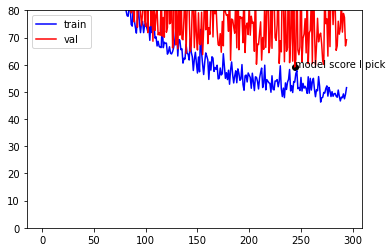

In [10]:
'''
[512, 512, 512, 512] -> 89.7
[256, 256, 256, 256] -> 90.23
[256, 256, 256, 256, 128] -> 90.39
[256, 256, 256, 128, 128] -> 90.425
[256, 256, 256, 128, 64] -> 90.467
[256, 256, 256, 256, 64] -> 90.848

[512, 512, 512] -> 86.35
[512, 512, 512, 128] -> 86.82

'''

tf.random.set_seed(42)
test_params = [
                
    
    [512, 512, 512, 128]

              ]
model = run_sim(test_params)

## Save model
Save model to participate in compititon on keggle

In [171]:
pred = model.predict(X_test_scale)
df_X_test = pd.DataFrame(pred)
df_X_test = df_X_test.reset_index()
df_X_test = df_X_test.rename(columns={'index':'Id', 0:'Predicted'})

In [172]:
df_X_test.to_csv('predicted.csv', index=False)